# Teste Data Science Elo7

### Descrição do Problema

Construir um classificador de produtos que recebe um conjunto de características de um produto e retorna a categoria dele.

### Dataset

Em resumo, o dataset contém 38.507 registros distribuídos em 5 categorias (Bebê, Bijuterias e Jóias, Decoração, Lembrancinhas, Papel e Cia e Outros). Cada registro corresponde a um clique em um produto a partir de um termo de busca no site.

Nesse dataset você encontrará as seguintes colunas:

 - product_id - identificação de produto
 - seller_id - identificação do vendedor
 - query - termo de busca inserido pelo usuário
 - search_page - número da página que o produto apareceu nos resultados de busca (mín 1 e máx 5)
 - position - número da posição que o produto apareceu dentro da página de busca (mín 0 e máx 38)
 - title - título do produto
 - concatenated_tags - tags do produto inseridas pelo vendedor (as tags estão concatenadas por espaço)
 - creation_date - data de criação do produto na plataforma do Elo7
 - price - preço do produto em reais
 - weight - peso em gramas da unidade do produto reportado pelo vendedor
 - express_delivery - indica se o produto é pronta entrega (1) ou não (0)
 - minimum_quantity - quantidade de unidades mínima necessária para compra
 - view_counts - número de cliques no produto nos últimos três meses
 - order_counts - número de vezes que o produto foi comprado nos últimos três meses
 - category - categoria do produto

# Importando as Bibliotecas

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)

# Leitura dos Dados

In [5]:
dados = pd.read_csv('elo7_recruitment_dataset.csv')
dados.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


In [6]:
print('O conjunto de dados possui ',dados.shape[0],'linhas e ',dados.shape[1],'colunas.')

O conjunto de dados possui  38507 linhas e  15 colunas.


# Limpeza e Tratamento dos Dados

In [7]:
dados.dtypes

product_id             int64
seller_id              int64
query                 object
search_page            int64
position               int64
title                 object
concatenated_tags     object
creation_date         object
price                float64
weight               float64
express_delivery       int64
minimum_quantity       int64
view_counts            int64
order_counts         float64
category              object
dtype: object

In [8]:
dados.isnull().sum()

product_id               0
seller_id                0
query                    0
search_page              0
position                 0
title                    0
concatenated_tags        2
creation_date            0
price                    0
weight                  58
express_delivery         0
minimum_quantity         0
view_counts              0
order_counts         20390
category                 0
dtype: int64

O maior numero de dados nulos estão na coluna 'order_counts'. Essa coluna informa número de vezes que o produto foi comprado nos últimos três meses. Esses dados podem ser nulos pois esses produtos não apresentaram nenhuma venda nos ultimos 3 meses, partindo disso, poderiamos substituir os valores de NaN por zero.

In [9]:
dados.loc[dados['order_counts'].isna()]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração
5,4336889,3436479,dia dos pais,1,37,Álbum de figurinhas dia dos pais,albuns figurinhas pai lucas album fotos,2018-07-11 10:41:33,49.970000,208.0,1,1,1093,NaN,Lembrancinhas
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38498,2739553,7358636,polaina tricot,1,0,Polainas em Tricô,polainas,2013-07-15 16:58:47,55.870000,0.0,0,1,176,NaN,Bebê
38501,9920560,5631760,lembrancinhas para mulheres,1,0,Lembrancinha Chá de Mulheres,lembrancas lembrancinhas lembrancinha cha mulh...,2018-02-21 10:51:06,14.510000,10.0,0,14,535,NaN,Lembrancinhas
38504,972256,4840665,copo metalizado,1,3,Copos Metalizados - Rosé,despedida bianca metalizados xvdakaw lembranci...,2018-02-17 15:53:23,11.580000,25.0,1,104,306,NaN,Lembrancinhas
38505,7291315,6420917,festa do pijama menino,1,36,Kit Festa do Pijama Meninos,festa pijama,2016-08-21 22:33:59,131.330000,0.0,1,11,55,NaN,Lembrancinhas


In [10]:
dados.loc[dados['order_counts']==0.0]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category


In [11]:
dados['order_counts'] = dados['order_counts'].fillna(0)

In [12]:
dados.isnull().sum()

product_id            0
seller_id             0
query                 0
search_page           0
position              0
title                 0
concatenated_tags     2
creation_date         0
price                 0
weight               58
express_delivery      0
minimum_quantity      0
view_counts           0
order_counts          0
category              0
dtype: int64

Existem 58 dados nulos na coluna 'weight', provavelmente o vendedor não informou o peso do produto. Como são poucos dados em relação ao numero total de dados do conjunto, podemos excluir esses dados.

In [13]:
dados.loc[dados['weight'].isna()]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
1764,15179518,2520540,sabonete,2,30,Sabonete líquido,sabonete sabonete liquido maternidade,2010-02-23 08:55:19,3.200000,NaN,0,15,104,0.0,Outros
2321,16688789,9060983,kit homenageados 15 anos,1,29,Kit homenageados pink e branco,15 anos,2012-10-28 21:16:10,24.310000,NaN,1,4,34,0.0,Lembrancinhas
2477,10145823,1417817,lembrancinha de casamento,4,15,lembrancinha de casamento,lembrancinhas,2012-08-07 21:05:36,14.030000,NaN,0,0,232,0.0,Lembrancinhas
4038,9797453,6000437,saco roupa suja,1,15,Saco para roupa suja,saco roupa suja,2011-09-01 05:44:28,35.340000,NaN,0,4,8,0.0,Outros
4115,10807030,139807,convite 90 anos,1,26,CONVITE DE 90 ANOS,convites personalizados 10x15,2012-09-23 09:43:45,12.060000,NaN,1,15,48,0.0,Papel e Cia
5257,12242119,431519,cartao de agradecimento cha de fraldas,1,3,TAG/MINI CARTÃO - CHÁ DE FRALDAS,bebes tags cartoes,2010-07-27 16:59:18,9.870000,NaN,1,34,104,0.0,Papel e Cia
5892,3301068,3058025,lembrancinha de maternidade diferente,1,12,"Lembrancinhas, aniversário, maternidade",lembrancinhas maternidade tata bloquinhos lemb...,2012-07-28 12:31:23,15.000000,NaN,1,24,962,0.0,Bebê
6532,12775302,10020204,cartao dia dos pais,1,2,Cartão Dia dos Pais,cartoes,2012-08-10 14:56:30,12.190000,NaN,1,0,228,0.0,Papel e Cia
7034,13613187,546025,tapete para banheiro de barbante,1,19,Tapetes de Barbantes,tapetes barbante decoracao tapete barbante,2012-05-28 10:12:27,243.340000,NaN,1,0,95,0.0,Decoração
7307,11038478,7879862,lembranca,1,37,LEMBRANÇA DE CASAMENTO,009 casamento lembranca casamento casamento,2011-03-29 17:01:00,12.950000,NaN,1,22,227,0.0,Outros


O mesmo raciocínio adotado para tratar os valores nulos da coluna 'weight' pode ser adotada para a coluna 'concatenated_tags', que tem apenas 2 valores nulos.

In [11]:
dados.loc[dados['concatenated_tags'].isna()]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
6359,9247896,8344716,stranger things,2,30,Caixinha Stranger Things,NaN,2018-06-01 23:13:18,62.9,329.0,1,5,121,10.0,Decoração
29809,8132534,6790389,prateleira para gatos,1,5,Kit Ponte Passarela para Gatos com 2 prateleiras,NaN,2018-03-28 15:29:07,107.8,3808.0,0,1,202,7.0,Outros


In [14]:
dados.dropna(inplace=True)

In [15]:
dados.isnull().sum()

product_id           0
seller_id            0
query                0
search_page          0
position             0
title                0
concatenated_tags    0
creation_date        0
price                0
weight               0
express_delivery     0
minimum_quantity     0
view_counts          0
order_counts         0
category             0
dtype: int64

In [16]:
print('O conjunto de dados possui ',dados.shape[0],'linhas e ',dados.shape[1],'colunas após excluirmos os valores nulos.')

O conjunto de dados possui  38447 linhas e  15 colunas após excluirmos os valores nulos.


In [17]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38447 entries, 0 to 38506
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_id         38447 non-null  int64  
 1   seller_id          38447 non-null  int64  
 2   query              38447 non-null  object 
 3   search_page        38447 non-null  int64  
 4   position           38447 non-null  int64  
 5   title              38447 non-null  object 
 6   concatenated_tags  38447 non-null  object 
 7   creation_date      38447 non-null  object 
 8   price              38447 non-null  float64
 9   weight             38447 non-null  float64
 10  express_delivery   38447 non-null  int64  
 11  minimum_quantity   38447 non-null  int64  
 12  view_counts        38447 non-null  int64  
 13  order_counts       38447 non-null  float64
 14  category           38447 non-null  object 
dtypes: float64(3), int64(7), object(5)
memory usage: 4.7+ MB


# Análise Exploratória

Essa parte consiste na exploração dos dados, com o objetivo de conhecer os dados e tirar algumas informações que podem ser importantes para o sistema de classificação.

### Estatísticas Descritivas

In [46]:
dados.describe()

,product_id,seller_id,search_page,position,price,weight,express_delivery,minimum_quantity,view_counts,order_counts
count,3.844700e+04,3.844700e+04,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000,38447.000000
mean,8.341086e+06,5.009940e+06,1.491690,16.892918,84.122273,361.747965,0.780555,14.603766,545.986397,12.901709
std,4.835196e+06,2.947308e+06,0.980153,11.589345,211.952413,1820.777260,0.413876,43.800200,1417.489218,43.743231
min,3.610000e+02,8.170000e+02,1.000000,0.000000,0.070000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,4.137908e+06,2.473568e+06,1.000000,6.000000,12.760000,6.000000,1.000000,3.000000,119.000000,0.000000
50%,8.371889e+06,4.917720e+06,1.000000,16.000000,28.529999,9.000000,1.000000,7.000000,243.000000,0.000000
75%,1.252850e+07,7.638876e+06,2.000000,27.000000,90.000000,107.000000,1.000000,16.000000,521.000000,14.000000
max,1.669295e+07,1.011887e+07,5.000000,38.000000,11509.380000,65009.000000,1.000000,3000.000000,45010.000000,2460.000000


A função describe mostra algumas informações estatísticas sobre as variáveis numericas. Temos a contagem de variáveis, o valor da média de cada variável, o desvio padrão, o valor mínimo e máximo, o percentil inferior e superior (25% e 75%) e o percentil de 50% que é o mesmo que a mediana.

Podemos ver que a coluna do peso ('weight') possui valor mínimo igual a zero. Esses valores estão errados, será necessário exclui-los do conjunto de dados. Antes de excluir, vamos ver quantos valores são iguais a zero.

In [47]:
dados.loc[dados['weight']==0.0]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
14,5257665,8519033,chinelo personalizado casamento,3,9,Chinelo personalizado casamento azul,porta guardanapos casamento lembrancas casorio,2017-12-28 00:55:28,5.890000,0.0,1,53,311,0.0,Lembrancinhas
18,9082256,4680202,sacola personalizada dia dos pais,2,15,Caneca Dia dos Pais Personalizada - Feliz Dia ...,canecas personalizadas,2018-07-14 09:14:56,24.900000,0.0,1,1,78,1.0,Lembrancinhas
25,7340505,4131779,lembrancinha de 15 anos,1,18,LEMBRANCINHA 15 ANOS,15 anos casamento,2011-11-05 00:20:58,18.170000,0.0,1,10,343,0.0,Lembrancinhas
30,7621260,7274093,saia para berco americano,1,29,Saia para Berço Americano,enxoval acessorios,2015-07-03 22:04:37,84.700000,0.0,1,9,82,25.0,Bebê
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38476,14166766,4548056,lembrancinhas dia do professor,1,2,Lembrancinha Dia dos Professores,lembrancinha dia professores,2016-03-26 10:27:14,22.780000,0.0,1,10,268,0.0,Lembrancinhas
38478,5385130,8444884,tubolata,1,36,Lembrança Tubolata Ferrari,kit personalizados ferrari tubolata,2017-05-02 23:06:18,15.760000,0.0,1,15,65,0.0,Lembrancinhas
38488,11489843,1820260,caneca personalizada dia dos pais,2,31,Caneca Inox Personalizada 180ml C/ Tampa,brindes casamento dia pais lembrancinhas casorio,2017-02-01 13:51:55,20.910000,0.0,1,20,352,0.0,Lembrancinhas
38498,2739553,7358636,polaina tricot,1,0,Polainas em Tricô,polainas,2013-07-15 16:58:47,55.870000,0.0,0,1,176,0.0,Bebê


Temos 4398 observações com valor de peso igual a zero. Isso representa 11,43% do total de observações. Se olharmos quais produtos estão com peso igual a zero, vemos muitos produtos diferentes, e alguns são bem genericos, por exemplo o produto "Lembrancinha Dia dos Professores". Não dá pra saber que tipo de lembrancinha é, as vezes o vendedor produz varios tipos de lembrancinhas e dependendo do tipo escolhido pelo cliente o peso vai ser diferente. O que explicaria a variável peso não ter nenhum peso especificado. 

O problema de deixar essa variável igual a zero, é que sua distribuição será afetada por isso, o que pode também influenciar o sistema de classificação. Temos duas opções aqui, ou excluimos esses dados, ou substituimos por outro valor. Vamos olhar as estatísticas descritivas da variável peso quando os dados são agrupados por categoria.

In [18]:
dados.groupby('category')['weight'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Bebê,7015.0,394.424804,1425.323738,0.0,6.0,9.0,209.0,55007.0
Bijuterias e Jóias,951.0,61.232387,366.584620,0.0,6.0,9.0,19.0,8006.0
Decoração,8836.0,989.146446,3091.792320,0.0,7.0,156.0,712.0,65009.0
Lembrancinhas,17746.0,63.299560,277.027696,0.0,6.0,9.0,29.0,11006.0
Outros,1137.0,765.503078,4296.793777,0.0,7.0,10.0,175.0,60009.0
Papel e Cia,2762.0,126.434830,538.097324,0.0,6.0,8.0,30.0,15007.0


Os valores de peso por categoria possuem um desvio padrão bem alto, variando bastante. Talvez a decisão mais segura seja excluir os dados em que a variável peso é igual a zero.

In [19]:
excluir = dados.loc[dados['weight']==0.0]

In [20]:
dados.drop(excluir.index,axis=0,inplace=True)

In [21]:
print('O conjunto de dados possui ',dados.shape[0],'linhas e ',dados.shape[1],'colunas após excluirmos os valores iguais a zero da variável peso.')

O conjunto de dados possui  34049 linhas e  15 colunas após excluirmos os valores iguais a zero da variável peso.


Quantos valores unicos existem em cada coluna do conjunto de dados?

In [22]:
dados.nunique()

product_id           26935
seller_id             8101
query                 6199
search_page              5
position                39
title                23079
concatenated_tags    21020
creation_date        26931
price                13985
weight                1194
express_delivery         2
minimum_quantity       157
view_counts           2981
order_counts           344
category                 6
dtype: int64

Existem 26.935 produtos nesse conjunto de dados, 8.101 vendedores e 6.199 termos de busca diferentes utilizados.

Se temos 34.049 linhas no conjunto de dados, e 26.935 produtos, então existem produtos que aparecem mais de uma vez. Lembrando que, cada linha do conjunto de dados corresponde a um clique em um produto a partir de um termo de busca no site.

Quais os produtos aparecem mais de uma vez no conjunto de dados?

In [45]:
dados['product_id'].value_counts().sort_values(ascending=False)

7557702     14
11130723    12
2952037     11
9715550     11
9059093     10
            ..
9151626      1
9542797      1
14111892     1
13879166     1
14243630     1
Name: product_id, Length: 26935, dtype: int64

In [46]:
dados.loc[dados['product_id']==7557702]

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
1286,7557702,8888785,lembrancinha para o dia dos pais,1,14,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,10.30,57.0,1,15,3175,39.0,Lembrancinhas
1688,7557702,8888785,lembrancinha personalizada dia dos pais,1,0,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,20.18,57.0,1,16,3201,37.0,Lembrancinhas
2438,7557702,8888785,pais,3,16,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,18.45,50.0,1,15,3167,39.0,Lembrancinhas
6270,7557702,8888785,presente dia dos pais,2,14,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,20.27,50.0,1,13,3186,39.0,Lembrancinhas
8859,7557702,8888785,lembrancinha dia dos pais,2,1,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,20.47,60.0,1,10,3192,43.0,Lembrancinhas
23449,7557702,8888785,dia dos pais,1,13,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,18.33,56.0,1,10,3175,54.0,Lembrancinhas
24019,7557702,8888785,lembrancinha kit barbear dia dos pais,1,1,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,19.81,56.0,0,10,3185,32.0,Lembrancinhas
25582,7557702,8888785,presente personalizado dia dos pais,4,13,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,20.56,55.0,1,19,3150,32.0,Lembrancinhas
26312,7557702,8888785,kit barbear dia dos pais,1,1,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,10.30,57.0,1,10,3184,42.0,Lembrancinhas
28216,7557702,8888785,lembrancinhas corporativas dia dos pais,1,24,DIA DOS PAIS-KIT DE BARBEAR,dia pais lembranca personalizada,2018-07-19 20:02:41,18.86,58.0,1,15,3186,32.0,Lembrancinhas


In [51]:
aux = pd.DataFrame({'qtd_duplicado':dados['product_id'].value_counts().sort_values(ascending=False)})
aux.query('qtd_duplicado >1').count()

qtd_duplicado    5020
dtype: int64

Existem 5020 produtos que aparecem mais de uma vez no conjunto de dados.

Quantos produtos possuem pronta entrega e quantos não? Qual a porcentagem que isso representa?

In [23]:
dados['express_delivery'].value_counts()

1    26423
0     7626
Name: express_delivery, dtype: int64

In [24]:
dados['express_delivery'].value_counts()/dados.shape[0]

1    0.776029
0    0.223971
Name: express_delivery, dtype: float64

A maioria dos produtos (77,6%) estão disponíveis a pronta entrega.

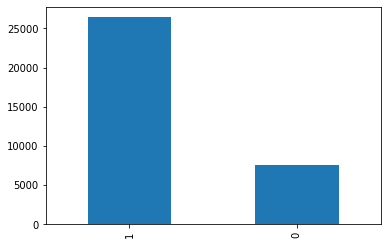

In [25]:
dados['express_delivery'].value_counts().plot(kind='bar')

Quantas observações há em cada categoria? Qual a porcentagem que isso representa?

In [26]:
dados['category'].value_counts()

Lembrancinhas         15533
Decoração              8070
Bebê                   6153
Papel e Cia            2419
Outros                 1036
Bijuterias e Jóias      838
Name: category, dtype: int64

In [27]:
dados['category'].value_counts()/dados.shape[0]

Lembrancinhas         0.456195
Decoração             0.237011
Bebê                  0.180710
Papel e Cia           0.071045
Outros                0.030427
Bijuterias e Jóias    0.024612
Name: category, dtype: float64

O conjunto de dados é composto por 6 categorias, sendo a maior parte das observações, 45,61%, pertence a categoria de Lembrancinhas, 23,7% pertence a categoria de Decoração e 18,07% a categoria de Bebê. Essas 3 categorias representam a maior parte do conjunto de dados. As outras 3 categorias representam a menor porcentagem dos dados, a categoria Papel e Cia possui 7,1% dos dados, Bijuteria e Jóias 3% e 2,46% estão na categoria Outros.

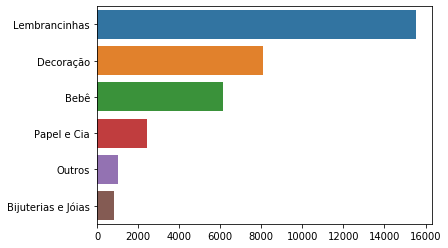

In [28]:
sns.barplot(dados['category'].value_counts().values,dados['category'].value_counts().index)

Quantos vendedores existem em cada categoria?

In [41]:
dados.groupby('category')['seller_id'].nunique().sort_values(ascending=False)

category
Lembrancinhas         3037
Decoração             2628
Bebê                  1890
Papel e Cia            887
Outros                 488
Bijuterias e Jóias     340
Name: seller_id, dtype: int64

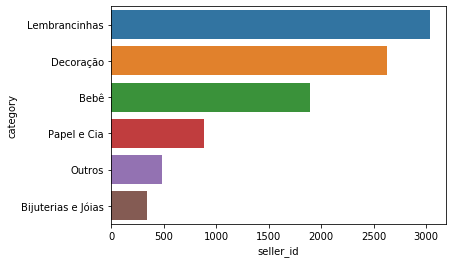

In [39]:
sns.barplot(dados.groupby('category')['seller_id'].nunique().sort_values(ascending=False),
            dados.groupby('category')['seller_id'].nunique().sort_values(ascending=False).index)

Quanto produtos existem em cada categoria?

In [42]:
dados.groupby('category')['product_id'].nunique().sort_values(ascending=False)

category
Lembrancinhas         11509
Decoração              6836
Bebê                   4857
Papel e Cia            2034
Outros                  930
Bijuterias e Jóias      769
Name: product_id, dtype: int64

Como é a distribuição da variável preço?

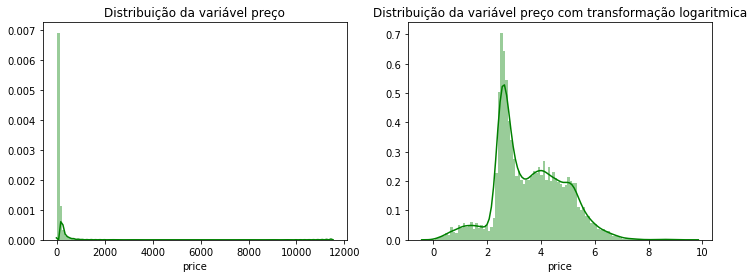

In [29]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.distplot(dados['price'], color='g', bins=100, hist_kws={'alpha': 0.4}, ax=axs[0])
sns.distplot(np.log1p(dados['price']), color='g', bins=100, hist_kws={'alpha': 0.4}, ax=axs[1])
axs[0].set_title('Distribuição da variável preço')
axs[1].set_title('Distribuição da variável preço com transformação logaritmica')
plt.show()

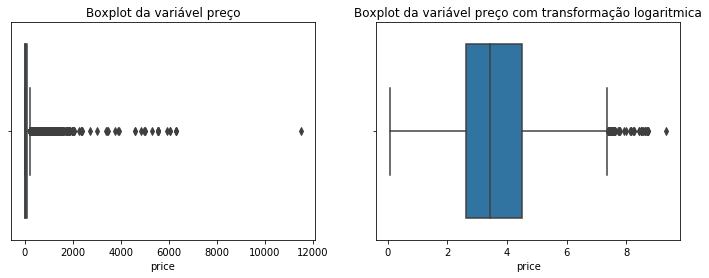

In [30]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(dados['price'],ax=axs[0])
sns.boxplot(np.log1p(dados['price']),ax=axs[1])
axs[0].set_title('Boxplot da variável preço')
axs[1].set_title('Boxplot da variável preço com transformação logaritmica')
plt.show()

In [31]:
dados['price'].describe()

count    34049.000000
mean        84.314645
std        210.955558
min          0.070000
25%         12.810000
50%         29.380000
75%         90.770000
max      11509.380000
Name: price, dtype: float64

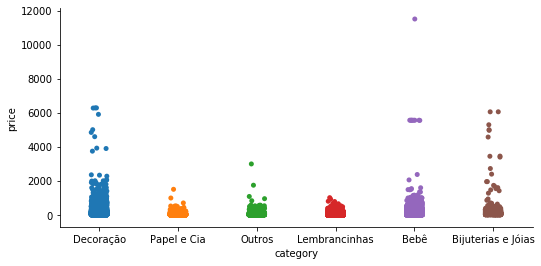

In [32]:
ax = sns.catplot(x='category', y='price',data=dados, aspect=2, height=3.8)

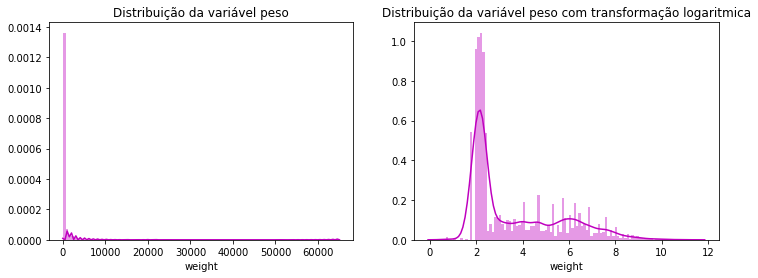

In [33]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.distplot(dados['weight'], color='m', bins=100, hist_kws={'alpha': 0.4}, ax=axs[0])
sns.distplot(np.log1p(dados['weight']), color='m', bins=100, hist_kws={'alpha': 0.4}, ax=axs[1])
axs[0].set_title('Distribuição da variável peso')
axs[1].set_title('Distribuição da variável peso com transformação logaritmica')
plt.show()

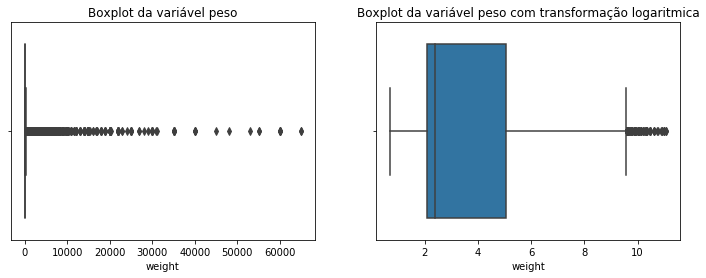

In [34]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.boxplot(dados['weight'],ax=axs[0])
sns.boxplot(np.log1p(dados['weight']),ax=axs[1])
axs[0].set_title('Boxplot da variável peso')
axs[1].set_title('Boxplot da variável peso com transformação logaritmica')
plt.show()

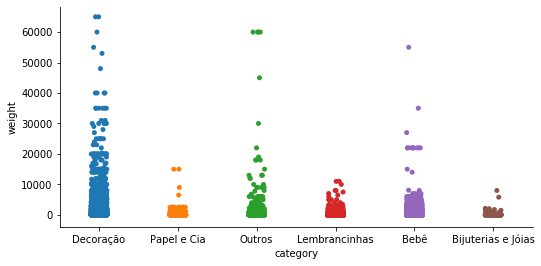

In [35]:
ax = sns.catplot(x='category', y='weight',data=dados, aspect=2, height=3.8)